# Support Vector Machines

**Overview**
* Class of supervised algorithms for both classification and regression

**Advantages**

* Their dependence on relatively few support vectors means that they are very compact models, and take up very little memory.
* Once the model is trained, the prediction phase is very fast.
* Because they are affected only by points near the margin, they work well with high-dimensional data - even data with more dimensions than samples, which is a challenging regime for other algorithms.
* Their integration with kernel methods makes them very versatile, able to adapt to many types of data.


**Disadvantages**

* The scaling with the number of samples $N$ is $\mathcal{O}[N^3]$ at worst, or $\mathcal{O}[N^2]$ for efficient implementations. For large numbers of training samples, this computational cost can be prohibitive.
* The results are strongly dependent on a suitable choice for the softening parameter $C$. This must be carefully chosen via cross-validation, which can be expensive as datasets grow in size.
* The results do not have a direct probabilistic interpretation. This can be estimated via an internal cross-validation (see the probability parameter of SVC), but this extra estimation is costly.


With those traits in mind, I generally only turn to SVMs once other simpler, faster, and less tuning-intensive methods have been shown to be insufficient for my needs. Nevertheless, if you have the CPU cycles to commit to training and cross-validating an SVM on your data, the method can lead to excellent results.

### Coding Example 1: A simple Division

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# use seaborn plotting defaults
import seaborn as sns; sns.set()

In [4]:
from sklearn.datasets.samples_generator import make_blobs
X, y = make_blobs(n_samples=50, centers=2,
                  random_state=0, cluster_std=0.60)

In [5]:
from sklearn.svm import SVC # "Support vector classifier"
model = SVC(kernel='linear', C=1E10)
model.fit(X, y)

SVC(C=10000000000.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [23]:
def plot_svc_decision_function(model, ax=None, plot_support=True):
    """Plot the decision function for a 2D SVC"""
    if ax is None:
        ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # create grid to evaluate model
    x = np.linspace(xlim[0], xlim[1], 30)
    y = np.linspace(ylim[0], ylim[1], 30)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)
    
    # plot decision boundary and margins
    ax.contour(X, Y, P, colors='k',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])
    
    # plot support vectors
    if plot_support:
        ax.scatter(model.support_vectors_[:, 0],
                   model.support_vectors_[:, 1],
                   s=300, linewidth=4, facecolors='black', alpha = 0.2);
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

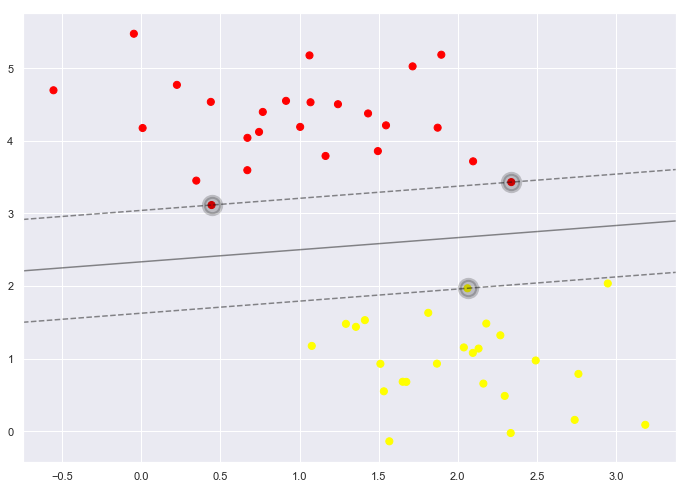

In [24]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(model);

This is the dividing line that __maximizes the margin__ between the two sets of points. The training points that touch the margin are the pivotal elements of this fit, and are known as the support vectors, and give the algorithm its name. In Scikit-Learn, the identity of these points are stored in the support_vectors_ attribute of the classifier:

In [9]:
model.support_vectors_

array([[0.44359863, 3.11530945],
       [2.33812285, 3.43116792],
       [2.06156753, 1.96918596]])

A key to this classifier's success is that for the fit, only the position of the support vectors matter; any points further from the margin which are on the correct side do not modify the fit! Technically, this is because these points do not contribute to the loss function used to fit the model, so their position and number do not matter so long as they do not cross the margin. This insensitivity to the exact behavior of distant points is one of the strengths of the SVM model.

### Coding Example 2: Kernel SVM

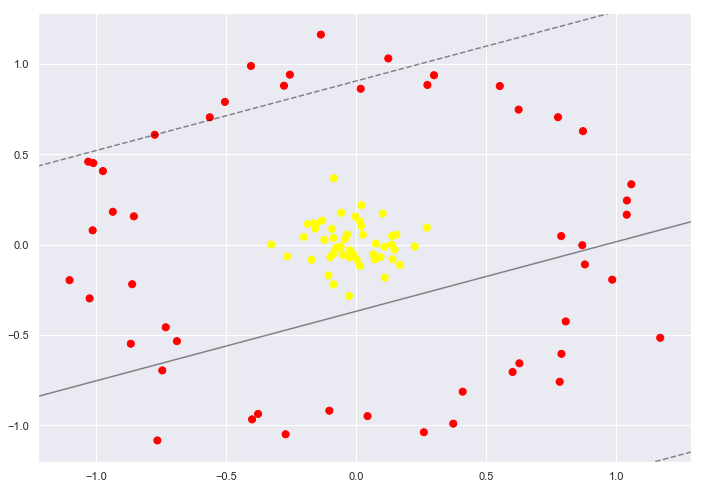

In [26]:
from sklearn.datasets.samples_generator import make_circles
X, y = make_circles(100, factor=.1, noise=.1)

clf = SVC(kernel='linear').fit(X, y)

plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(clf, plot_support=False);

It is clear that no linear discrimination will ever be able to separate this data. However we could think about how we might project the data into a higher dimension such that a linear separator would be sufficient. For example, one simple projection we could use would be to compute a radial basis function centered on the middle clump:

In [58]:
r = np.exp(-(X ** 2).sum(1))

We can visualize this extra data dimension using a three-dimensional plot:

In [65]:
from mpl_toolkits import mplot3d
from ipywidgets import interact
import ipywidgets as widgets

def plot_3D(elev=-90, azim=30, X=X, y=y):
    ax = plt.subplot(projection='3d')
    ax.scatter3D(X[:, 0], X[:, 1], r, c=y, s=50, cmap='autumn')
    ax.view_init(elev=30, azim=azim)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('r')

interact(plot_3D, elev=[-45, 45], azip=(-180, 180), X=fixed(X), y=fixed(y));

interactive(children=(Dropdown(description='elev', options=(-45, 45), value=-45), IntSlider(value=30, descript…

In Scikit-Learn, we can apply kernelized SVM simply by changing our linear kernel to an RBF (radial basis function) kernel, using the kernel model hyperparameter:

In [68]:
clf = SVC(kernel='rbf', C=1E6, gamma='auto')
clf.fit(X, y)

SVC(C=1000000.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

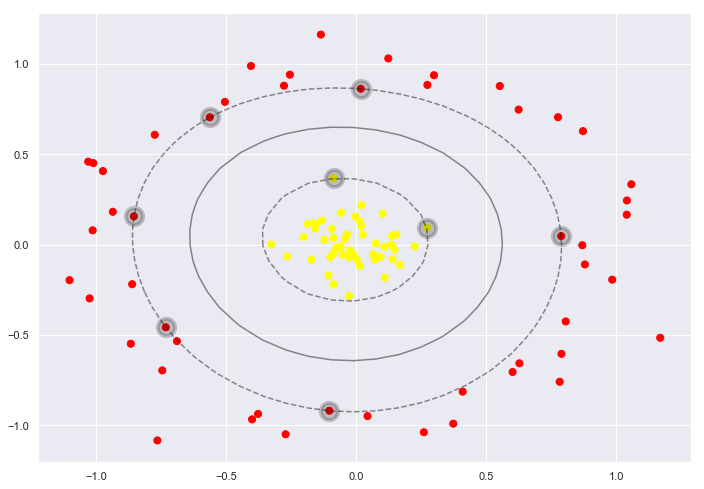

In [69]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(clf)
plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1],
            s=300, lw=1, facecolors='none');

Using this kernelized support vector machine, we learn a suitable nonlinear decision boundary. This kernel transformation strategy is used often in machine learning to turn fast linear methods into fast nonlinear methods, especially for models in which the kernel trick can be used.

### Coding Example 3: Softening Margins

The following data does have some amount of overlap:

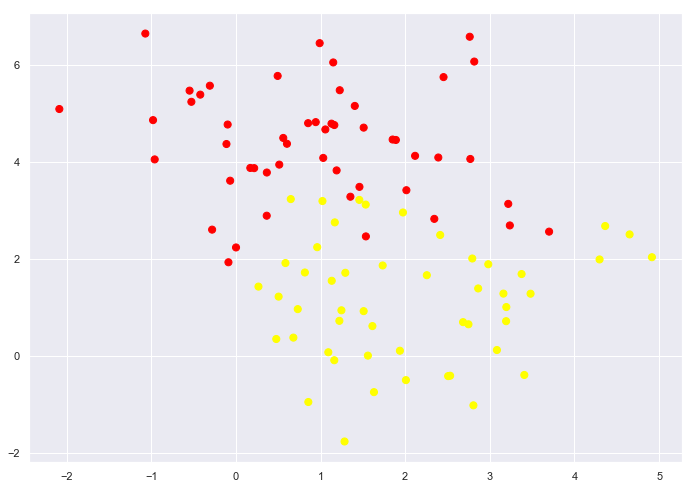

In [70]:
X, y = make_blobs(n_samples=100, centers=2,
                  random_state=0, cluster_std=1.2)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn');

To handle this case, the SVM implementation has a bit of a fudge-factor which "softens" the margin: that is, it allows some of the points to creep into the margin if that allows a better fit. The hardness of the margin is controlled by a tuning parameter, most often known as $C$. For very large $C$, the margin is hard, and points cannot lie in it. For smaller $C$, the margin is softer, and can grow to encompass some points.

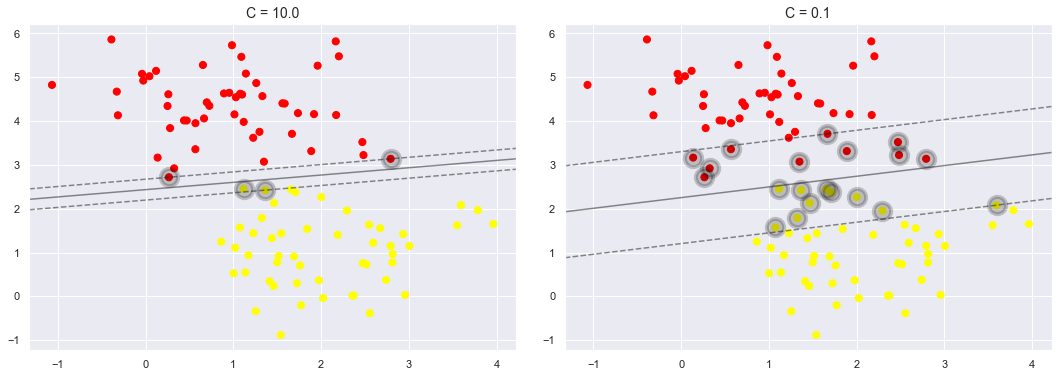

In [79]:
# Showing the effect of changing the C parameter:
C1 = 10.0
C2 = 0.1
X, y = make_blobs(n_samples=100, centers=2,
                  random_state=0, cluster_std=0.8)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)

for axi, C in zip(ax, [C1, C2]):
    model = SVC(kernel='linear', C=C).fit(X, y)
    axi.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
    plot_svc_decision_function(model, axi)
    axi.scatter(model.support_vectors_[:, 0],
                model.support_vectors_[:, 1],
                s=300, lw=1, facecolors='none');
    axi.set_title('C = {0:.1f}'.format(C), size=14)

The optimal value of the $C$ parameter will depend on your dataset, and should be tuned using cross-validation or a similar procedure.